In [1]:
import sys
sys.path.insert(1, '/scratch/cinthiasouza/mv-text-summarizer')

import glob, os
import pandas as pd
import json
import spacy
import nltk
import numpy as np
import json
#import smogn
import seaborn as sns
import pickle

from bs4 import BeautifulSoup
from pysbd.utils import PySBDFactory
import math

from sumeval.metrics.rouge import RougeCalculator
rouge = RougeCalculator(stopwords=True, lang="en")
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import matthews_corrcoef
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
#from tensorflow.keras.models import model_from_json

#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

#!python -m spacy download en_core_web_sm
nlp_sm = spacy.load('en_core_web_sm')

#import en_core_web_sm
#nlp_md = en_core_web_sm.load()y

#import en_core_web_md
#nlp_md = en_core_web_md.load()
#!python -m spacy download en_core_web_md
nlp_md = spacy.load('en_core_web_md')

import warnings
warnings.filterwarnings("ignore")

path_base = "/scratch/cinthiasouza/mv-text-summarizer"


In [2]:
%load_ext autoreload
%autoreload 2

from src import preprocess
from src import extract_features
from src import tokenizer
from src import create_features_df
from src import transform_data
from src import loader
from src import utils
from src import ensemble_tree_models
from src import tunning_hyperparametrs as th
#from src import mlp_regressor
#from src import mlp_classifier
from src import summarization
from src import normalization
from src import ensemble_tree_models as classifiers
from src import utils_classification as utils_clf
from src import evaluate_classifiers as ev
from src import prepare_data
from src import display_results as dr
import joblib
from joblib import Parallel, delayed
#from tensorflow.keras.utils import to_categorical
from src import pipeline_extract_features as pef

# Load Features

In [184]:
len(pd.unique(features_intro['articles']))

4718

In [181]:
#import random

#features_intro, scores_intro = loader.read_features(path="../result/introduction/features_*.csv")
#features_mat, scores_mat = loader.read_features(path="../result/materials/features_*.csv")
#features_conc, scores_conc = loader.read_features(path="../result/conclusion/features_*.csv")

#intro = pd.unique(features_intro['articles'])
#mat = pd.unique(features_mat['articles'])
#conc = pd.unique(features_conc['articles'])

#comuns = list((set(intro) & set(mat)) & set(conc))

#valid_len = int(len(comuns)*0.2)
#summ_items = random.sample(comuns, valid_len)

#df = pd.DataFrame({'summ': summ_items})
#df.to_csv("indices_summ.csv", index=False)

In [182]:
def main(path='.', format_dataset=True, verbose=True):
    
    columns_name = ['text_rank', 'lex_rank', 'count_one_gram',
        'count_article_keywords', 'tf-isf', 'position_score', 'paragraph_score',
       'length_score', 'pos_score', 'ner_score', 'dist_centroid']

    sections=['introduction', 'materials', 'conclusion', 'concat']
    #sections=[ 'introduction']

    if format_dataset:
        if verbose:
            print("Preparando dataset para os classificadores")
        dataset = prepare_data.main_create_dataset(columns_name, sections)
        #utils.save_json(dataset, name='dataset', path=path)
    else:
        if verbose:
            print("Carregando dataset")
        dataset = utils.load_json(name='dataset', path=path)
    
    if verbose:
        print("Treinamento dos modelos")
        
    with open('dataset2.p', 'wb') as fp:
        pickle.dump(dataset, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return dataset
    
    '''models = ensemble_tree_models.create_models(dataset, sections, name_models=['knn', 'gb', 'rf', 'ab'])
    predictions, results = ev.create_reports(models, dataset, columns_name, verbose=False)
    
    #utils.save_json(predictions, name='prediction', path=path)
    #utils.save_results(results, path=path)
    
    parameters = {'introduction': [0.2, 100, 64],
             'materials': [0.2, 100, 64],
             'conclusion':[0.2, 100, 64],
             'concat': [0.2, 100, 64]}

    models_nn = mlp_classifiers.main_train_nn(dataset, sections, parameters, train=True, verbose=False)
    predictions, results =  mlp_classifiers.eval_nn(dataset, sections)'''
    

In [ ]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--path', "-p",required=True)
    parser.add_argument('--format_dataset', "-f",required=True)
     
    args = parser.parse_args()

    columns_name = ['text_rank', 'lex_rank', 'count_one_gram',
        'count_article_keywords',
       'tf-isf', 'position_score', 'paragraph_score',
       'length_score', 'pos_score', 'ner_score', 'dist_centroid']

    sections=['introduction', 'materials', 'conclusion', 'concat']

In [183]:
dataset = main(verbose=True)

Preparando dataset para os classificadores
Treinamento dos modelos


In [377]:
dataset['introduction'][2]

array([1, 0, 1, ..., 0, 0, 1])

In [3]:
with open('dataset.p', 'rb') as fp:
    dataset = pickle.load(fp)

In [4]:
columns_name = ['text_rank', 'lex_rank', 'count_one_gram',
        'count_article_keywords',
       'tf-isf', 'position_score', 'paragraph_score',
       'length_score', 'pos_score', 'ner_score', 'dist_centroid']

sections=['introduction', 'materials', 'conclusion', 'concat']

## Randomized Search -  CV 5 Folds

In [381]:
all_parameters = {'gb': {'n_estimators': [50,  100, 200],
              'min_samples_leaf':[5, 20, 100],
              'min_samples_split':[10, 40, 200],
              'max_depth':[ 5, 10, 20, 50]
              },
              'knn':  {'n_neighbors': [3,  5, 10]},
              'ab': {'n_estimators': [50,  100, 200]}
                 }

In [390]:
def get_parameters(dataset, name_models, all_parameters, sections):
    
    for name_model in name_models:

        if name_model == 'knn':
            parameters = all_parameters['knn']
        elif name_model == 'ab':
            parameters = all_parameters['ab'],
        else:
            parameters = all_parameters['gb']
 
        for section in sections:
        
            search = ensemble_tree_models.pipeline(dataset, name_model=name_model, section=section, parameters=parameters)
      

In [387]:
from multiprocessing import Process, Queue

name_models = ['knn', 'rf', 'ab', 'gb']
sections = ['introduction', 'materials', 'conclusion']
l1 = Queue()
p1 = Process(
    target=get_parameters, args=(
         dataset, name_models, all_parameters, sections))
p1.start()   

In [5]:
def load_rs_model(name_model, sections, path_to_read):
    
    rs_models = {}
    
    for section in sections:
        
        rs_models[section] = joblib.load('{}/search_{}_{}.pkl'.format(path_to_read, name_model, section))
        
    return rs_models

In [6]:
def  get_scores(name_models, sections, path_to_read):

    results = {}
    
    for name_model in name_models:
        
        rs_models = load_rs_model(name_model, sections, path_to_read)
    
        aux  = { 'score_{}'.format(section): rs_models[section].best_score_ for section in sections}
        results[name_model] = aux
        
    return results

In [8]:
path_to_save = '/scratch/cinthiasouza/mv-text-summarizer/notebook/models'

In [11]:
sections=['introduction', 'materials', 'conclusion']
name_models = ['knn', 'rf', 'ab', 'gb']

results = get_scores(name_models, sections, path_to_save)

## Results K-Fold Cross Validation

In [12]:
cv_results = pd.DataFrame(results).T
cv_results

,score_introduction,score_materials,score_conclusion
knn,0.658445,0.690085,0.676967
rf,0.692736,0.728925,0.715229
ab,0.690103,0.727749,0.707874
gb,0.695255,0.729512,0.712715


## Hyperparameters

### KNN

In [13]:
knnsearch = load_rs_model('knn', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num neighbors: {}\n".format(knnsearch[section].best_estimator_.n_neighbors))

Section: introduction
Num neighbors: 10

Section: materials
Num neighbors: 10

Section: conclusion
Num neighbors: 10



### AdaBoost

In [14]:
absearch = load_rs_model('ab', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num estimators: {}\n".format(absearch[section].best_estimator_.n_estimators))

Section: introduction
Num estimators: 100

Section: materials
Num estimators: 200

Section: conclusion
Num estimators: 100



### RF

In [15]:
rfsearch = load_rs_model('rf', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num estimators: {}".format(rfsearch[section].best_estimator_.n_estimators))
    print("Min samples leaf: {}".format(rfsearch[section].best_estimator_.min_samples_leaf))
    print("Min samples splot: {}".format(rfsearch[section].best_estimator_.min_samples_split))
    print("Max depth: {}\n".format(rfsearch[section].best_estimator_.max_depth))

Section: introduction
Num estimators: 100
Min samples leaf: 20
Min samples splot: 40
Max depth: 20

Section: materials
Num estimators: 100
Min samples leaf: 5
Min samples splot: 40
Max depth: 20

Section: conclusion
Num estimators: 100
Min samples leaf: 5
Min samples splot: 40
Max depth: 20



### GB

In [16]:
gbsearch = load_rs_model('gb', sections, path_to_save)

for section in sections:
    print("Section: {}".format(section))
    print("Num estimators: {}".format(gbsearch[section].best_estimator_.n_estimators))
    print("Min samples leaf: {}".format(gbsearch[section].best_estimator_.min_samples_leaf))
    print("Min samples splot: {}".format(gbsearch[section].best_estimator_.min_samples_split))
    print("Max depth: {}\n".format(gbsearch[section].best_estimator_.max_depth))


Section: introduction
Num estimators: 50
Min samples leaf: 5
Min samples splot: 10
Max depth: 5

Section: materials
Num estimators: 100
Min samples leaf: 100
Min samples splot: 10
Max depth: 5

Section: conclusion
Num estimators: 50
Min samples leaf: 100
Min samples splot: 10
Max depth: 5



## Train Test

In [26]:
parameters = {
    'gb' : {
        'introduction': {'n_estimators': 50,
              'min_samples_leaf':5,
              'min_samples_split':10,
              'max_depth':5},
        'materials': {'n_estimators': 100,
              'min_samples_leaf':100,
              'min_samples_split':10,
              'max_depth':5},
        'conclusion': {'n_estimators': 50,
              'min_samples_leaf':100,
              'min_samples_split':10,
              'max_depth': 5},
        'concat': {'n_estimators': 50,
              'min_samples_leaf':100,
              'min_samples_split':10,
              'max_depth': 5},
    },
    'rf' : {
        'introduction': {'n_estimators': 100,
              'min_samples_leaf':20,
              'min_samples_split':40,
              'max_depth':20},
        'materials': {'n_estimators': 100,
              'min_samples_leaf':5,
              'min_samples_split':40,
              'max_depth':20},
        'conclusion': {'n_estimators': 100,
              'min_samples_leaf':5,
              'min_samples_split':40,
              'max_depth': 20},
        'concat': {'n_estimators': 200,
              'min_samples_leaf':5,
              'min_samples_split':10,
              'max_depth': 50}
    },
    'ab' : {
        'introduction': {'n_estimators': 100},
        'materials': {'n_estimators': 200},
        'conclusion': {'n_estimators': 100},
        'concat': {'n_estimators': 100}
    },
    'knn': {
        'introduction': {'n_neighbors': 10},
        'materials': {'n_neighbors': 10},
        'conclusion': {'n_neighbors': 10},
        'concat': {'n_neighbors': 10}
    },
    'mlp': {
        'introduction': {'hidden_layer_sizes': (128,256,128,), 'activation': 'relu', 'max_iter':300, 'batch_size':64},
        'materials': {'hidden_layer_sizes': (128,256,128,), 'activation': 'relu', 'max_iter':300, 'batch_size': 64},
        'conclusion': {'hidden_layer_sizes': (128,256,128,), 'activation': 'relu', 'max_iter':300, 'batch_size': 64},
        'concat': {'hidden_layer_sizes': (128,256,128,200,), 'activation': 'relu', 'max_iter':300, 'batch_size': 64},
    }

}

In [27]:
sections=['introduction', 'materials', 'conclusion']
name_models = ['mlp']

In [28]:
from multiprocessing import Process, Queue

l1 = Queue()
p1 = Process(
    target=classifiers.create_models, args=(
         dataset, parameters, sections, name_models))
p1.start()   


In [5]:
def load_classifiers(sections, path_to_read, name_models):

    models = {}
    
    for section in sections:
        
        aux = {}
        
        for name_model in name_models:
            aux[name_model] = joblib.load('{}/{}_{}.pkl'.format(path_to_read, name_model,  section))
            
        models[section] = aux
        
    return models

In [18]:
path_to_save = '/scratch/cinthiasouza/mv-text-summarizer/notebook/models'

sections=['introduction', 'materials', 'conclusion']
name_models = ['knn', 'rf', 'ab', 'gb', 'mlp']

models = load_classifiers(sections, path_to_save, name_models)

In [19]:
predictions, predictions_proba, results = ev.create_reports(models, dataset, columns_name, name_models, verbose=False)

In [20]:
dr.display_results(results, section='introduction')

,model,precision,recall,f1-score,support
0,knn,0.911390,0.730881,0.811215,7937.000000
1,knn,0.260900,0.572079,0.358365,1318.000000
accuracy,knn,0.708266,0.708266,0.708266,0.708266
macro avg,knn,0.586145,0.651480,0.584790,9255.000000
weighted avg,knn,0.818754,0.708266,0.746725,9255.000000
,model,precision,recall,f1-score,support
0,ab,0.926976,0.700517,0.797991,7937.000000
1,ab,0.270187,0.667678,0.384699,1318.000000
accuracy,ab,0.695840,0.695840,0.695840,0.695840
macro avg,ab,0.598581,0.684097,0.591345,9255.000000


,model,precision,recall,f1-score,support
0,rf,0.927947,0.709084,0.803885,7937.000000
1,rf,0.276176,0.668437,0.390861,1318.000000
accuracy,rf,0.703296,0.703296,0.703296,0.703296
macro avg,rf,0.602061,0.688761,0.597373,9255.000000
weighted avg,rf,0.835129,0.703296,0.745067,9255.000000
,model,precision,recall,f1-score,support
0,gb,0.929573,0.710092,0.805143,7937.000000
1,gb,0.279135,0.676024,0.395122,1318.000000
accuracy,gb,0.705240,0.705240,0.705240,0.705240
macro avg,gb,0.604354,0.693058,0.600132,9255.000000


,model,precision,recall,f1-score,support
0,mlp,0.930316,0.719919,0.811705,7937.000000
1,mlp,0.285898,0.675266,0.401715,1318.000000
accuracy,mlp,0.713560,0.713560,0.713560,0.713560
macro avg,mlp,0.608107,0.697592,0.606710,9255.000000
weighted avg,mlp,0.838545,0.713560,0.753319,9255.000000


In [21]:
dr.display_results(results, section='materials')

,model,precision,recall,f1-score,support
0,knn,0.980956,0.723175,0.832568,45657.000000
1,knn,0.051055,0.514762,0.092896,1321.000000
accuracy,knn,0.717314,0.717314,0.717314,0.717314
macro avg,knn,0.516005,0.618968,0.462732,46978.000000
weighted avg,knn,0.954808,0.717314,0.811769,46978.000000
,model,precision,recall,f1-score,support
0,ab,0.985558,0.674113,0.800614,45657.000000
1,ab,0.055242,0.658592,0.101933,1321.000000
accuracy,ab,0.673677,0.673677,0.673677,0.673677
macro avg,ab,0.520400,0.666353,0.451274,46978.000000


,model,precision,recall,f1-score,support
0,rf,0.985168,0.701229,0.819295,45657.000000
1,rf,0.057942,0.635125,0.106196,1321.000000
accuracy,rf,0.699370,0.699370,0.699370,0.699370
macro avg,rf,0.521555,0.668177,0.462745,46978.000000
weighted avg,rf,0.959095,0.699370,0.799243,46978.000000
,model,precision,recall,f1-score,support
0,gb,0.986262,0.677684,0.803360,45657.000000
1,gb,0.057029,0.673732,0.105157,1321.000000
accuracy,gb,0.677572,0.677572,0.677572,0.677572
macro avg,gb,0.521645,0.675708,0.454259,46978.000000


,model,precision,recall,f1-score,support
0,mlp,0.985518,0.667718,0.796073,45657.000000
1,mlp,0.054413,0.660863,0.100547,1321.000000
accuracy,mlp,0.667525,0.667525,0.667525,0.667525
macro avg,mlp,0.519965,0.664290,0.448310,46978.000000
weighted avg,mlp,0.959335,0.667525,0.776515,46978.000000


In [22]:
dr.display_results(results, section='conclusion')

,model,precision,recall,f1-score,support
0,knn,0.987582,0.723101,0.834896,70058.000000
1,knn,0.034299,0.519608,0.064350,1326.000000
accuracy,knn,0.719321,0.719321,0.719321,0.719321
macro avg,knn,0.510940,0.621354,0.449623,71384.000000
weighted avg,knn,0.969874,0.719321,0.820583,71384.000000
,model,precision,recall,f1-score,support
0,ab,0.989491,0.714993,0.830139,70058.000000
1,ab,0.038245,0.598793,0.071897,1326.000000
accuracy,ab,0.712835,0.712835,0.712835,0.712835
macro avg,ab,0.513868,0.656893,0.451018,71384.000000


,model,precision,recall,f1-score,support
0,rf,0.989232,0.736932,0.844644,70058.000000
1,rf,0.039804,0.576169,0.074464,1326.000000
accuracy,rf,0.733946,0.733946,0.733946,0.733946
macro avg,rf,0.514518,0.656551,0.459554,71384.000000
weighted avg,rf,0.971595,0.733946,0.830337,71384.000000
,model,precision,recall,f1-score,support
0,gb,0.989602,0.714565,0.829889,70058.000000
1,gb,0.038467,0.603318,0.072323,1326.000000
accuracy,gb,0.712499,0.712499,0.712499,0.712499
macro avg,gb,0.514035,0.658942,0.451106,71384.000000


,model,precision,recall,f1-score,support
0,mlp,0.989376,0.664621,0.795116,70058.000000
1,mlp,0.033961,0.622926,0.064410,1326.000000
accuracy,mlp,0.663846,0.663846,0.663846,0.663846
macro avg,mlp,0.511668,0.643773,0.429763,71384.000000
weighted avg,mlp,0.971628,0.663846,0.781543,71384.000000


In [91]:
dr.display_results(results, section='concat')

KeyError: 'knn_concat'

# Matthews Correlation

In [12]:
df = ev.matthews(sections, dataset, predictions, name_models)
df

,introduction,materials,conclusion
knn,0.228466,0.087273,0.072875
rf,0.277598,0.120417,0.095347
ab,0.269433,0.116509,0.093290
gb,0.283876,0.123342,0.094460
mlp,0.230440,0.074082,0.074702


# ROC

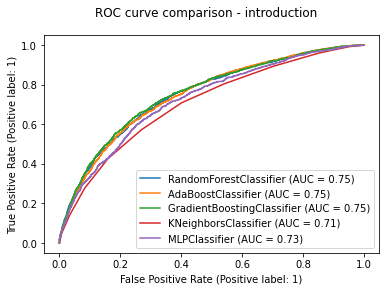

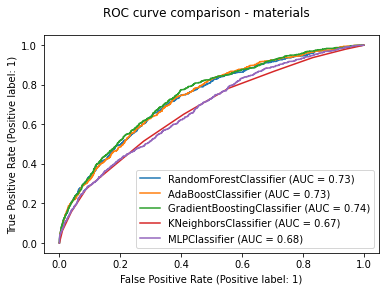

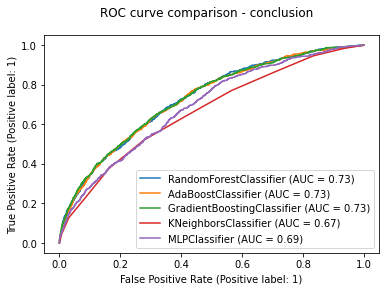

In [13]:
ev.roc_curve(sections, dataset, models)

# Summarization

In [ ]:
summ_items = pd.read_csv("indices_summ.csv")['summ']

path_base = "../../PMC003xxxxxx_pp"
references = [summarization.get_ref_summary(i, path_base) for i in summ_items]

In [301]:
X_test = features_intro.loc[features_intro['articles'].isin(summ_items)].reset_index(drop=True)
y_test = scores_intro.loc[scores_intro['articles'].isin(summ_items)].reset_index(drop=True)

In [345]:
def pipeline_summarization(features, scores, references, predictions, section, name_models, summ_items, proba=False):


    X_test = features.loc[features['articles'].isin(summ_items)]
    y_test = scores.loc[scores['articles'].isin(summ_items)]

    df = summarization.create_df(name_models, X_test, y_test['rouge_1'], predictions, section, proba=proba)
    if proba:
        df = binarize_proba(df, name_models)
    summaries = summarization.create_summaries(df, references, summ_items, name_models)
    result = evaluate_summaries(summaries, name_models)
    
    return df, summaries, result

In [ ]:
name_models = ['knn', 'ab', 'rf', 'gb', 'mlp']
section = 'introduction'

In [346]:
section = 'introduction'

df_intro, summaries_intro, result_intro = pipeline_summarization(
    features_intro, scores_intro, references, predictions_proba, section, name_models, summ_items, proba=True)

In [347]:
section = 'materials'

df_mat, summaries_mat, result_mat = pipeline_summarization(
    features_mat, scores_mat, references, predictions_proba, section, name_models, summ_items, proba=True)

In [348]:
section = 'conclusion'

df_conc, summaries_conc, result_conc = pipeline_summarization(
    features_conc, scores_conc, references, predictions_proba, section, name_models, summ_items, proba=True)

In [349]:
summaries_intro.describe()

,knn_r1,knn_r2,knn_rl,rf_r1,rf_r2,rf_rl,ab_r1,ab_r2,ab_rl,gb_r1,gb_r2,gb_rl,mlp_r1,mlp_r2,mlp_rl
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.199079,0.062900,0.133394,0.202613,0.065723,0.134990,0.198094,0.062657,0.130500,0.197265,0.062629,0.129628,0.202824,0.065681,0.135960
std,0.078438,0.049396,0.057671,0.079017,0.050403,0.055778,0.081593,0.050282,0.056522,0.079215,0.049757,0.055713,0.083111,0.052605,0.058959
min,0.012121,0.000000,0.012121,0.047619,0.000000,0.031008,0.030000,0.000000,0.030000,0.045627,0.000000,0.036145,0.044693,0.000000,0.031008
25%,0.143692,0.027313,0.095525,0.147458,0.027876,0.096483,0.139860,0.023599,0.087912,0.144618,0.025921,0.090524,0.144737,0.029056,0.092335
50%,0.195048,0.052610,0.125684,0.198924,0.057758,0.130900,0.188854,0.051355,0.123875,0.191238,0.051948,0.122898,0.195337,0.051948,0.131267
75%,0.239011,0.087624,0.155978,0.246982,0.091728,0.166667,0.244429,0.089139,0.159877,0.246182,0.087247,0.159152,0.249722,0.096000,0.166096
max,0.518519,0.301887,0.407407,0.467290,0.258065,0.370370,0.587302,0.274194,0.370370,0.470588,0.271186,0.370370,0.515152,0.261307,0.370370


In [350]:
summaries_mat.describe()

,knn_r1,knn_r2,knn_rl,rf_r1,rf_r2,rf_rl,ab_r1,ab_r2,ab_rl,gb_r1,gb_r2,gb_rl,mlp_r1,mlp_r2,mlp_rl
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.134960,0.056547,0.101735,0.131853,0.054215,0.099264,0.132041,0.056632,0.100773,0.126182,0.048444,0.092706,0.132686,0.054568,0.100661
std,0.106392,0.095179,0.094714,0.105189,0.095144,0.093524,0.114154,0.106626,0.104422,0.097097,0.083604,0.082600,0.109424,0.098819,0.098192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.063597,0.000000,0.045395,0.063492,0.000000,0.047619,0.061543,0.000000,0.046602,0.060991,0.000000,0.046101,0.058539,0.000000,0.045147
50%,0.109116,0.025834,0.077423,0.107047,0.022706,0.074074,0.106473,0.023599,0.076557,0.107625,0.021739,0.072706,0.110556,0.024490,0.078844
75%,0.174597,0.055254,0.117647,0.164898,0.051696,0.114902,0.164837,0.050484,0.114434,0.163886,0.050263,0.112767,0.171056,0.050794,0.121603
max,0.529412,0.511628,0.529412,0.505263,0.489362,0.505263,0.694215,0.689076,0.694215,0.502674,0.462312,0.487562,0.564103,0.521739,0.564103


In [351]:
summaries_conc.describe()

,knn_r1,knn_r2,knn_rl,rf_r1,rf_r2,rf_rl,ab_r1,ab_r2,ab_rl,gb_r1,gb_r2,gb_rl,mlp_r1,mlp_r2,mlp_rl
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.180714,0.067495,0.125541,0.175507,0.064203,0.121332,0.182599,0.070568,0.127526,0.179448,0.068601,0.125904,0.179512,0.066568,0.123755
std,0.107782,0.086123,0.087449,0.108387,0.091787,0.092708,0.110874,0.095094,0.094061,0.113134,0.098176,0.098237,0.110407,0.092820,0.092473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.108789,0.015240,0.073397,0.097862,0.012801,0.067869,0.108108,0.014351,0.068770,0.107487,0.013358,0.069137,0.107440,0.013224,0.069465
50%,0.165547,0.044821,0.108537,0.160460,0.035717,0.102302,0.165614,0.035398,0.102130,0.158083,0.036815,0.103134,0.158122,0.034633,0.103200
75%,0.223605,0.079446,0.150810,0.238049,0.077295,0.147638,0.239553,0.086822,0.156972,0.238563,0.079348,0.149083,0.237946,0.077055,0.146879
max,0.637931,0.542636,0.595420,0.676471,0.656716,0.676471,0.600000,0.595960,0.600000,0.695035,0.647482,0.695035,0.606061,0.595960,0.606061


In [352]:
summaries_comb = summarization.combine_summ(summaries_intro, summaries_mat, summaries_conc, references, name_models)

In [354]:
result_comb = evaluate_summaries(summaries_comb, name_models)

In [355]:
result_comb.describe()

,knn_r1,knn_r2,knn_rl,rf_r1,rf_r2,rf_rl,ab_r1,ab_r2,ab_rl,gb_r1,gb_r2,gb_rl,mlp_r1,mlp_r2,mlp_rl
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.307393,0.117979,0.180378,0.306195,0.115290,0.178052,0.306077,0.118752,0.181739,0.303561,0.113692,0.176295,0.306759,0.116070,0.180537
std,0.092903,0.087382,0.075725,0.092391,0.087080,0.076477,0.095344,0.090205,0.079229,0.088897,0.084913,0.075160,0.095449,0.089586,0.078509
min,0.083333,0.000000,0.065455,0.064516,0.000000,0.055300,0.085837,0.000000,0.047619,0.064516,0.000000,0.055300,0.076190,0.000000,0.052941
25%,0.244777,0.058920,0.127326,0.244240,0.053895,0.129087,0.242431,0.057059,0.130134,0.246020,0.057143,0.125496,0.236059,0.055315,0.131088
50%,0.301616,0.091256,0.162641,0.293304,0.089554,0.160000,0.299701,0.095077,0.168081,0.297444,0.092253,0.161231,0.298799,0.091048,0.162406
75%,0.357778,0.144805,0.210489,0.363324,0.147554,0.208641,0.362305,0.151329,0.212361,0.347170,0.149012,0.205392,0.370065,0.149614,0.205488
max,0.564815,0.485981,0.500000,0.573134,0.492537,0.525926,0.575875,0.517647,0.546296,0.601626,0.492537,0.525926,0.659176,0.588679,0.621723


In [367]:
summ = 50

In [368]:
result_comb['references'][summ]

'ensemble methods have been widely used to improve prediction accuracy over individual classifiers. in this paper, we achieve a few results about the prediction accuracies of ensemble methods for binary classification that are missed or misinterpreted in previous literature. first we show the upper and lower bounds of the prediction accuracies (i.e. the best and worst possible prediction accuracies) of ensemble methods. next we show that an ensemble method can achieve > 0.5 prediction accuracy, while individual classifiers have < 0.5 prediction accuracies. furthermore, for individual classifiers with different prediction accuracies, the average of the individual accuracies determines the upper and lower bounds. we perform two experiments to verify the results and show that it is hard to achieve the upper and lower bounds accuracies by random individual classifiers and better algorithms need to be developed.'

In [369]:
result_comb['mlp'][summ]

'Using ensemble methods to improve the prediction accuracy of classification problems has become a well established research area. An ensemble method usually has an odd number of individual classifiers and uses a simple majority voting rule, where the prediction goes with the majority of the individual classifiers . While previous research focuses on finding diverse classifiers to achieve better prediction accuracy, we show that the individual classifiers in an ensemble method that achieves the upper bound of the prediction accuracy are neither completely diverse nor completely converged.We assume there are n individual binary classifiers BCi for (1 â\x89¤ i â\x89¤ n) in an ensemble method EM and there is a sufficient large and evenly distributed training set T with N inputs (e.g. vectors) xj for (1 â\x89¤ j â\x89¤ N). For a given input xj, the output yj by EM is correct if and only if the outputs yij by at least k+1 individual classifiers are correct and the output yj by EM is incorre

In [312]:

pred = [i[1] for i in predictions_proba['introduction']['knn']]

In [335]:
df = summarization.create_df(name_models, X_test, y_test['rouge_1'], predictions_proba, 'introduction', proba=True)

In [327]:
df

,sentences,rouge_1,articles,knn,rf,ab,gb,mlp
0,Abnormal behaviors are seen in a range of capt...,0.285714,PMC3084485.json,0.7,0.443117,0.500010,0.486992,0.477208
1,Among nonhuman primates these behaviors includ...,0.258065,PMC3084485.json,0.2,0.380898,0.498889,0.297632,0.305736
2,In a laboratory setting the presence of abnorm...,0.315789,PMC3084485.json,0.2,0.230626,0.498244,0.222499,0.292685
3,"First, because abnormal behaviors are thought ...",0.375000,PMC3084485.json,0.5,0.274655,0.498293,0.216121,0.231436
4,"Second, the presence of abnormal behavior may ...",0.200000,PMC3084485.json,0.9,0.420264,0.499740,0.429324,0.662151
...,...,...,...,...,...,...,...,...
5323,There have been recent advancements in the pro...,0.444444,PMC3895329.json,0.8,0.604892,0.500482,0.632942,0.766365
5324,Determination of amyloid type is possible inde...,0.235294,PMC3895329.json,0.7,0.630625,0.500649,0.688197,0.713612
5325,This technical advancement also allows for mol...,0.176471,PMC3895329.json,0.8,0.777094,0.501472,0.844490,0.937828
5326,Herein we describe the mass spectrometry prote...,0.363636,PMC3895329.json,0.7,0.543978,0.500151,0.554820,0.772349


In [319]:
def create_label(df, name_model):

    label = [0 for i in range(len(df))]

    j = 0
    for index, row in df.sort_values(name_model, ascending=False).iterrows():
        label[index] = 1
        j +=1

        if j==3:
            break

    return label

In [323]:
import itertools

In [344]:
def binarize_proba(df, name_models):
    
    for name_model in name_models:

        labels = []

        for article in pd.unique(df['articles']):

            aux = df.loc[df['articles'] == article].reset_index(drop=True)
            labels.append(create_label(aux, name_model))

        merged = list(itertools.chain(*labels))
        df[name_model] = merged
        
    return df

In [338]:
summaries_intro = summarization.create_summaries(df, references, summ_items, name_models)
result = evaluate_summaries(summaries, name_models)

In [340]:
result.describe()

,knn_r1,knn_r2,knn_rl,rf_r1,rf_r2,rf_rl,ab_r1,ab_r2,ab_rl,gb_r1,gb_r2,gb_rl,mlp_r1,mlp_r2,mlp_rl
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.199079,0.062900,0.133394,0.202613,0.065723,0.134990,0.198094,0.062657,0.130500,0.197265,0.062629,0.129628,0.202824,0.065681,0.135960
std,0.078438,0.049396,0.057671,0.079017,0.050403,0.055778,0.081593,0.050282,0.056522,0.079215,0.049757,0.055713,0.083111,0.052605,0.058959
min,0.012121,0.000000,0.012121,0.047619,0.000000,0.031008,0.030000,0.000000,0.030000,0.045627,0.000000,0.036145,0.044693,0.000000,0.031008
25%,0.143692,0.027313,0.095525,0.147458,0.027876,0.096483,0.139860,0.023599,0.087912,0.144618,0.025921,0.090524,0.144737,0.029056,0.092335
50%,0.195048,0.052610,0.125684,0.198924,0.057758,0.130900,0.188854,0.051355,0.123875,0.191238,0.051948,0.122898,0.195337,0.051948,0.131267
75%,0.239011,0.087624,0.155978,0.246982,0.091728,0.166667,0.244429,0.089139,0.159877,0.246182,0.087247,0.159152,0.249722,0.096000,0.166096
max,0.518519,0.301887,0.407407,0.467290,0.258065,0.370370,0.587302,0.274194,0.370370,0.470588,0.271186,0.370370,0.515152,0.261307,0.370370


In [343]:
summaries['knn'][0]

'Moreover, these findings were based on non randomized studies or small randomized trials that enrolled highly selected patients. To address these gaps in knowledge, we performed a prospectively planned analysis of HRQOL among patients randomized to CAS versus CEA in CREST. In addition, we performed exploratory analyses to evaluate the association between periprocedural complications and HRQOL during 1 year follow up .'

In [302]:
X_test

,sentences,text_rank,lex_rank,count_one_gram,count_two_gram,count_three_gram,count_article_keywords,tf-isf,position_score,paragraph_score,number_citations,length_score,pos_score,ner_score,dist_centroid,articles
0,Abnormal behaviors are seen in a range of capt...,0.030098,0.038000,2,0,0,0,0.011356,1.000000,1,0,17,11,0,0.941431,PMC3084485.json
1,Among nonhuman primates these behaviors includ...,0.044082,0.033000,8,0,0,0,0.016082,1.000000,0,0,41,23,0,0.963876,PMC3084485.json
2,In a laboratory setting the presence of abnorm...,0.032724,0.041333,2,0,0,0,0.010081,0.960000,0,0,16,8,1,0.955306,PMC3084485.json
3,"First, because abnormal behaviors are thought ...",0.032529,0.040000,4,0,0,0,0.016673,0.920000,0,0,34,26,1,0.965164,PMC3084485.json
4,"Second, the presence of abnormal behavior may ...",0.024714,0.036667,3,0,0,0,0.010115,0.880000,0,0,12,8,1,0.934551,PMC3084485.json
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,There have been recent advancements in the pro...,0.063674,0.071429,3,0,0,1,0.025872,0.428571,1,0,33,17,2,0.929608,PMC3895329.json
5324,Determination of amyloid type is possible inde...,0.054831,0.071429,2,0,0,1,0.017002,0.357143,0,0,11,8,0,0.929983,PMC3895329.json
5325,This technical advancement also allows for mol...,0.099055,0.071429,4,0,0,1,0.024569,0.285714,0,0,28,15,2,0.941802,PMC3895329.json
5326,Herein we describe the mass spectrometry prote...,0.051638,0.071429,3,0,0,0,0.018356,0.214286,0,0,12,7,1,0.947580,PMC3895329.json
